# PBMC Superstate Figures

## Inputs

In [1]:
source('jupyterFunctions_perCellType.R')
source('jupyterFunctions_broadCellType.R')

In [2]:
data_prefix <- paste(sep='','../data/PBMCsuperstate/')

meta <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_meta.rds'))
snATAC_cellCount <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_snATAC_cellQC_cellCounts.rds'))
snRNA_cellCount <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_snRNA_cellQC_cellCounts.rds'))

PvT <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_tissue_ATAC_df.rds'))

Treg_diffPeaks <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_Treg_diffPeaks.rds'))
Treg_diffGenes <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_Treg_diffGenes.rds'))
TXH_diffPeaks <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_TXH_diffPeaks.rds'))
TXH_diffGenes <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_TXH_diffGenes.rds'))

peak_fragCt <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_peakFragCounts.rds'))
gene_UMICt <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_geneUMIcounts.rds'))

Treg_pxc_norm <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_Treg_snATAC_pxc_norm.rds'))
Treg_gxc_norm <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_Treg_snRNA_gxc_norm.rds'))
TXH_pxc_norm <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_TXH_snATAC_pxc_norm.rds'))
TXH_gxc_norm <- readRDS(paste(sep='',data_prefix,'PBMCsuperstate_TXH_snRNA_gxc_norm.rds'))

In [3]:
HTO_colors <- readRDS(paste(sep='',data_prefix,'../misc/HTO_hashtag_colors.rds'))
tissue_color <- 'slateblue3'
PBMC_color <- 'brown3'

In [26]:
save_dir <- NA #'../output_v14/' #or NA if don't want to save
file_extension <- '.pdf'
data_extension <- '_sourceData.txt'

## Cell QC

In [5]:
HTO_order <- c('PBMC TFH','PBMC TPH','PBMC CD25hi Treg','PBMC CD25int Treg')
hashtag_col <- 'snHTO_cellType'
if(!(hashtag_col %in% colnames(meta))) stop('Hashtag cell type column not in meta file')

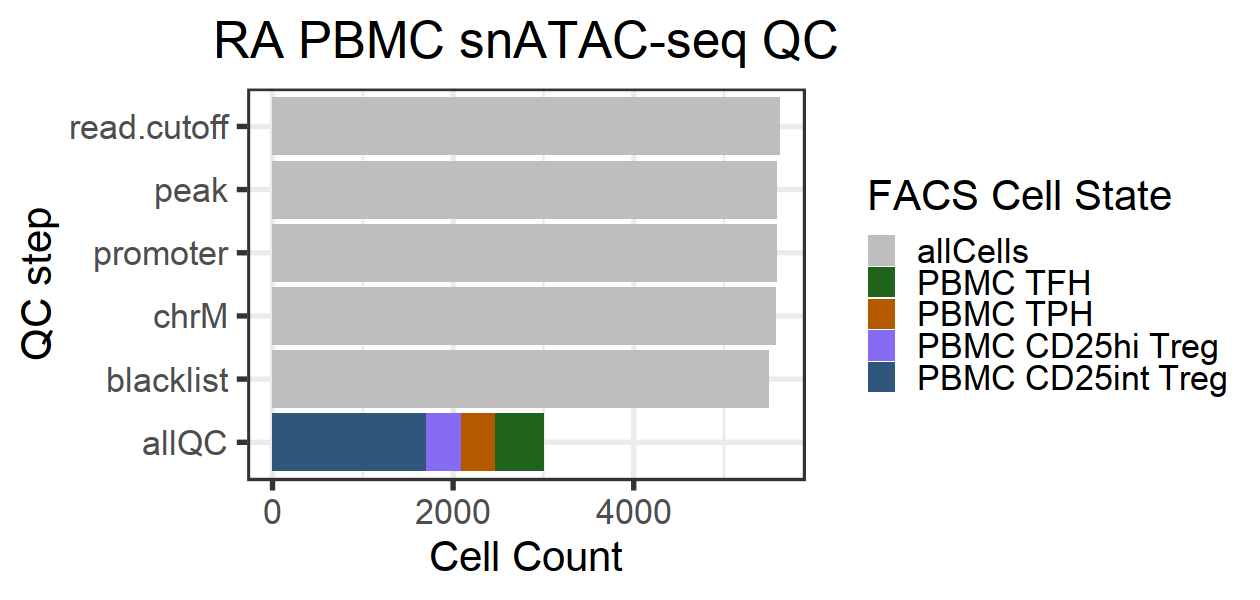

In [6]:
# Fig S15b left

options(repr.plot.height=5,repr.plot.width=10.5)
r <- QC_steps_barplot(snATAC_cellCount,meta,hashtag_col,HTO_colors,HTO_order,
                      tLab='RA PBMC snATAC-seq QC',fLab='FACS Cell State')
g <- r$plot
df <- r$data
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,'PBMCsuperstate_snATAC_QCsteps',file_extension),
           plot=g,units='in',height=5,width=10.5,dpi=600)
    write.table(df,paste(sep='',save_dir,'PBMCsuperstate_snATAC_QCsteps',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

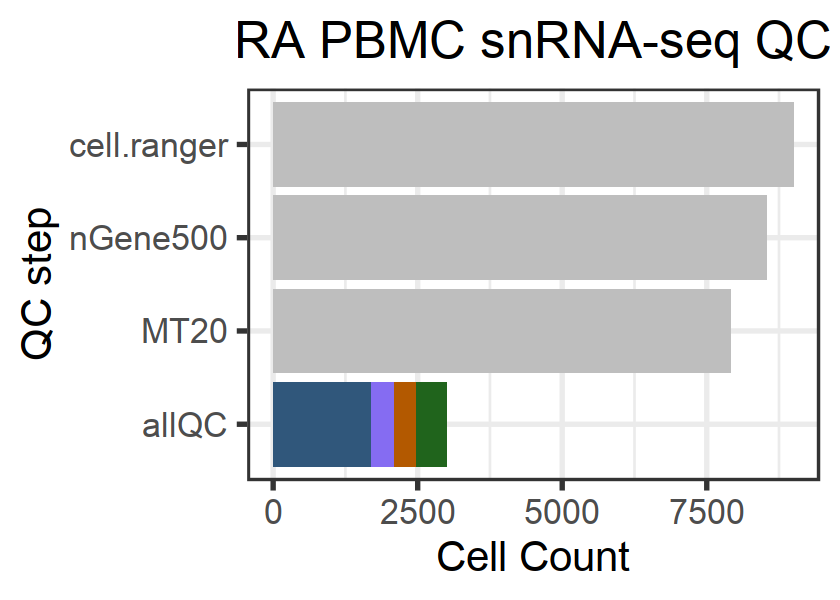

In [7]:
# Fig S15b right

options(repr.plot.height=5,repr.plot.width=7)
r <- QC_steps_barplot(snRNA_cellCount,meta,hashtag_col,HTO_colors,HTO_order,
                      tLab='RA PBMC snRNA-seq QC',fLab='FACS Cell State')
g <- r$plot
df <- r$data
g <- g + theme(legend.position="none")
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,'PBMCsuperstate_snRNA_QCsteps',file_extension),
           plot=g,units='in',height=5,width=7,dpi=600)
    write.table(df,paste(sep='',save_dir,'PBMCsuperstate_snRNA_QCsteps',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

## PBMC vs Tissue

In [8]:
superstate_res <- 'hres_0.50'
if(!(superstate_res %in% colnames(PvT))) stop('cluster resolution not in df')

In [9]:
Tcell_tissue_clusters <- sort(unique(PvT[which(PvT$bio_src=='tissue'),'bio_src_cellType']))
Tcell_PBMC_clusters <- sort(unique(PvT[which(PvT$bio_src=='PBMC'),'bio_src_cellType']))

Tcell_colors <- c(rep(tissue_color,length(Tcell_tissue_clusters)),rep(PBMC_color,length(Tcell_PBMC_clusters)))
names(Tcell_colors) <- c(Tcell_tissue_clusters,Tcell_PBMC_clusters)

In [10]:
ll <- table(PvT[which(PvT$bio_src=='PBMC'),'bio_src_cellType'])
any(ll[ll<10])

[1] FALSE

In [11]:
superstate_original_order <- c('TA-0: CD8A+ GZMK+',
                               'TA-4: CD8A+ PRF1+ cytotoxic',
                               'TA-1: CD4+ IL7R+',
                               'TA-2: CD4+ PD-1+ TFH/TPH','PBMC TFH/TPH',
                               'TA-3: CD4+ IKZF2+ Treg','PBMC Treg')
if(!all(superstate_original_order %in% unique(PvT$bio_src_cellType))) stop('original order insufficient')

PvT_order <- c(1,3,5,0,7,2,6,4,8,9)
if(!all(PvT_order %in% unique(PvT[,superstate_res]))) stop('cluster order insufficient')

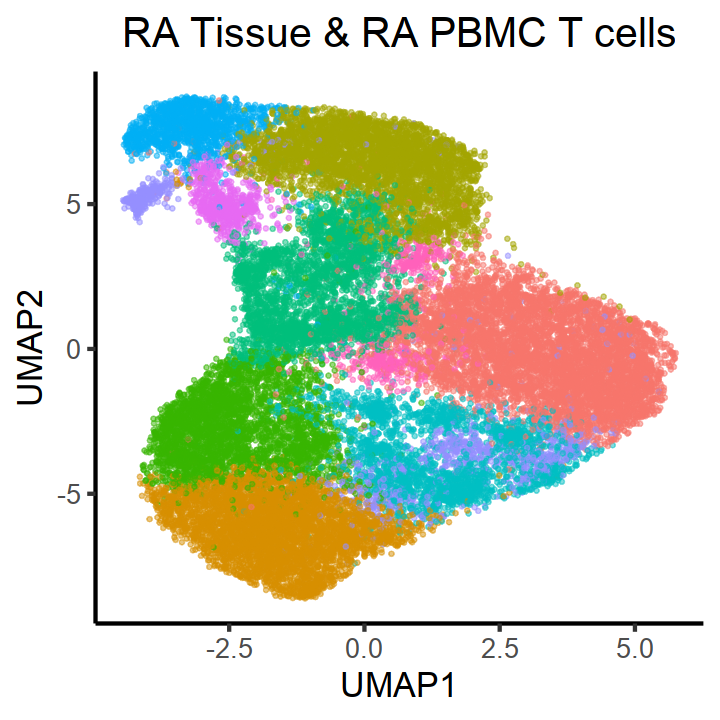

In [12]:
#Fig S15c left

superstate_cluster_colors <- hue_pal()(length(unique(PvT[,superstate_res])))
names(superstate_cluster_colors) <- sort(unique(PvT[,superstate_res]))

options(repr.plot.height=6,repr.plot.width=6)
g <- ggplot(PvT,aes_string(x='UMAP1',y='UMAP2',color=superstate_res)) + 
        rasterise(geom_point(size=1,alpha=0.5),dpi=300) + theme_classic(base_size=20) + 
        scale_color_manual(values=superstate_cluster_colors) + 
        theme(legend.position="none") +
        ggtitle('RA Tissue & RA PBMC T cells') + theme(plot.title = element_text(hjust = 0.5))
print(g)

df <- PvT[,c('UMAP1','UMAP2',superstate_res)]
colnames(df) <- c('UMAP1','UMAP2',paste('RA Tissue and PBMC T cells',superstate_res))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,'PBMCsuperstate_PBMCvsTissue_UMAP',file_extension),
           plot=g,units='in',height=6,width=6,dpi=600)
    write.table(df,paste(sep='',save_dir,'PBMCsuperstate_PBMCvsTissue_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

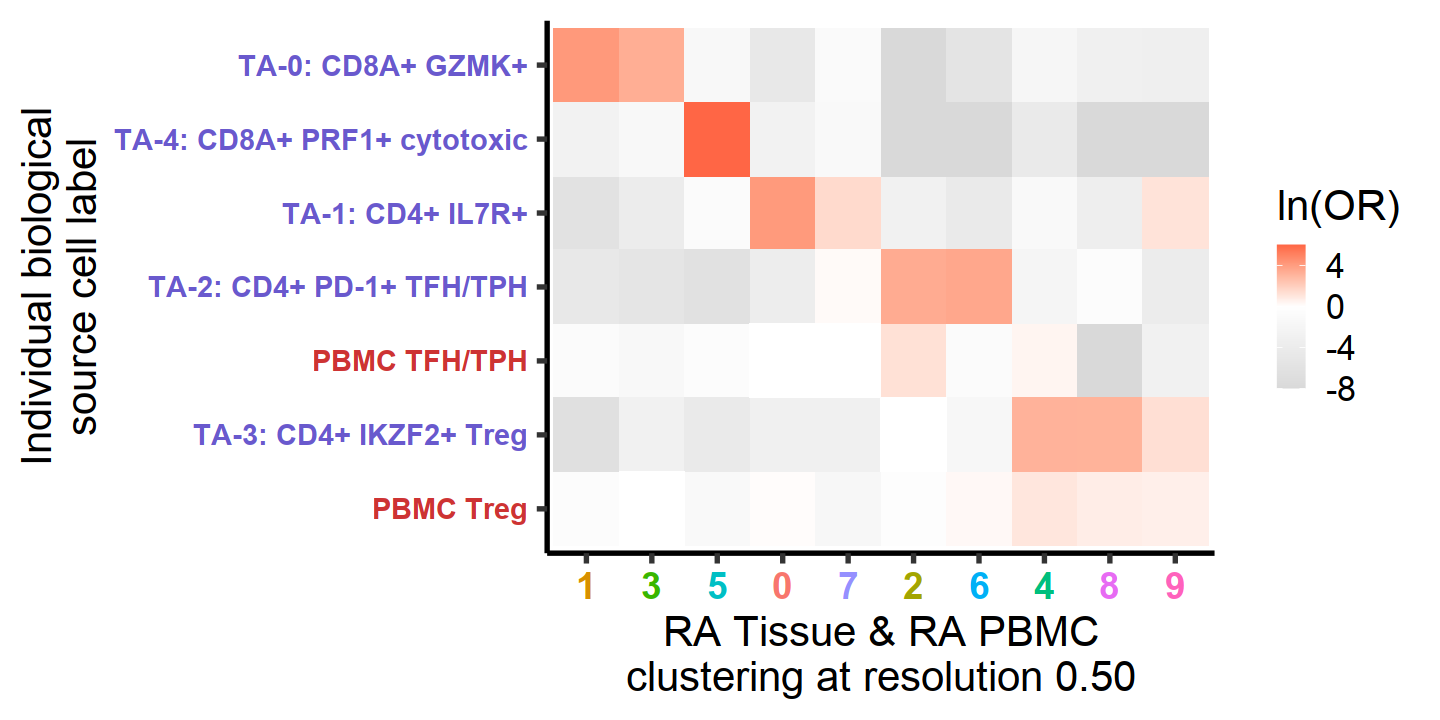

In [13]:
#Fig S15c right

superstate_fisher_df <- calc_OR(PvT,superstate_res, 'bio_src_cellType')

g <- plot_OR(superstate_fisher_df, superstate_res, 'bio_src_cellType',
             paste('RA Tissue & RA PBMC\nclustering at resolution',str_split_fixed(superstate_res,'_',2)[,2]),
             'Individual biological\nsource cell label',
             PvT_order, superstate_original_order,clustColors=c(Tcell_colors,superstate_cluster_colors))
g <- g + theme(axis.text.x=element_text(size=22),axis.text.y=element_text(size=17))

options(repr.plot.height=6,repr.plot.width=12)
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,save_dir,'PBMCsuperstate_PBMCvsTissue_ORheatmap',file_extension),
                            plot=g,units='in',height=6,width=12,dpi=600)

In [14]:
superstate_fisher_df[which(superstate_fisher_df[,superstate_res]==2 & 
                           (superstate_fisher_df$bio_src_cellType %in% c('TA-2: CD4+ PD-1+ TFH/TPH','PBMC TFH/TPH'))),]
superstate_fisher_df[which(superstate_fisher_df[,superstate_res]==4 & 
                           (superstate_fisher_df$bio_src_cellType %in% c('TA-3: CD4+ IKZF2+ Treg','PBMC Treg'))),]

,hres_0.50,bio_src_cellType,inX_inY,inX_noY,noX_inY,noX_noY,pval,OR,nullOR,CI_low,CI_high,sig,padj,sigBH,signif,lnOR
,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<chr>,<dbl>
15,2,PBMC TFH/TPH,339,3616,567,21644,2.985811e-63,3.578496,1,3.104122,4.12016,TRUE,5.648832e-63,TRUE,BH,1.274943
19,2,TA-2: CD4+ PD-1+ TFH/TPH,2806,1149,1560,20651,0.000000e+00,32.317034,1,29.629300,35.28733,TRUE,0.000000e+00,TRUE,BH,3.475594


,hres_0.50,bio_src_cellType,inX_inY,inX_noY,noX_inY,noX_noY,pval,OR,nullOR,CI_low,CI_high,sig,padj,sigBH,signif,lnOR
,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<chr>,<dbl>
30,4,PBMC Treg,526,2551,1566,21523,7.00574e-71,2.833763,1,2.541193,3.156677,TRUE,1.401148e-70,TRUE,BH,1.041606
34,4,TA-3: CD4+ IKZF2+ Treg,1814,1263,1279,21810,0.00000e+00,24.493651,1,22.335758,26.846693,TRUE,0.000000e+00,TRUE,BH,3.198414


## mRNA clustering

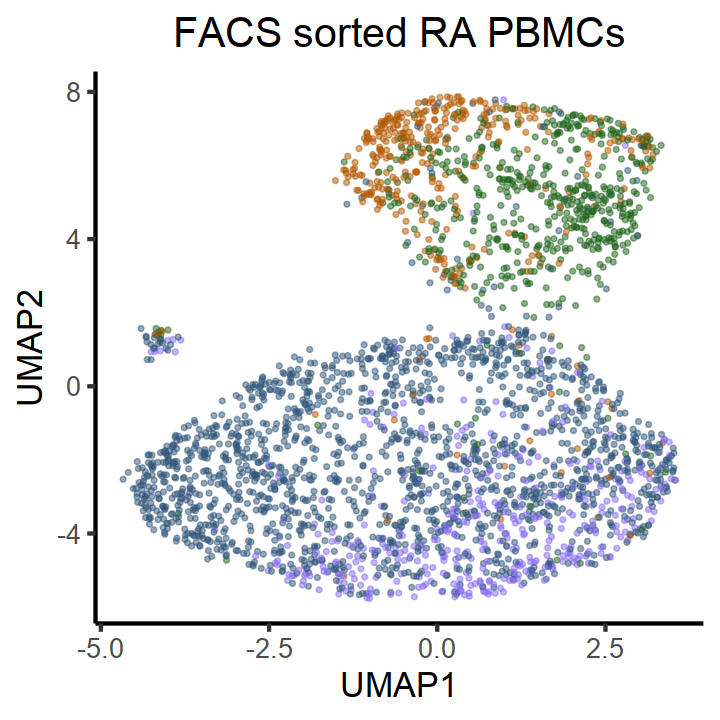

In [15]:
#Fig S15d left

mRNA_res <- 'snRNA_hres_0.55'

options(repr.plot.height=6,repr.plot.width=6)
g <- ggplot(meta,aes_string(x='snRNA_UMAP1',y='snRNA_UMAP2',color=hashtag_col)) + 
        geom_point(size=1,alpha=0.5) + theme_classic(base_size=20) + 
        scale_color_manual(values=HTO_colors) + 
        theme(legend.position="none") + labs(x='UMAP1',y='UMAP2') +
        ggtitle('FACS sorted RA PBMCs') + theme(plot.title = element_text(hjust = 0.5))
print(g)

df <- meta[,c('snRNA_UMAP1','snRNA_UMAP2',hashtag_col)]
colnames(df) <- c('UMAP1','UMAP2','FACS Cell State')

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,'PBMCsuperstate_mRNA_UMAP',file_extension),
           plot=g,units='in',height=6,width=6,dpi=600)
    write.table(df,paste(sep='',save_dir,'PBMCsuperstate_mRNA_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

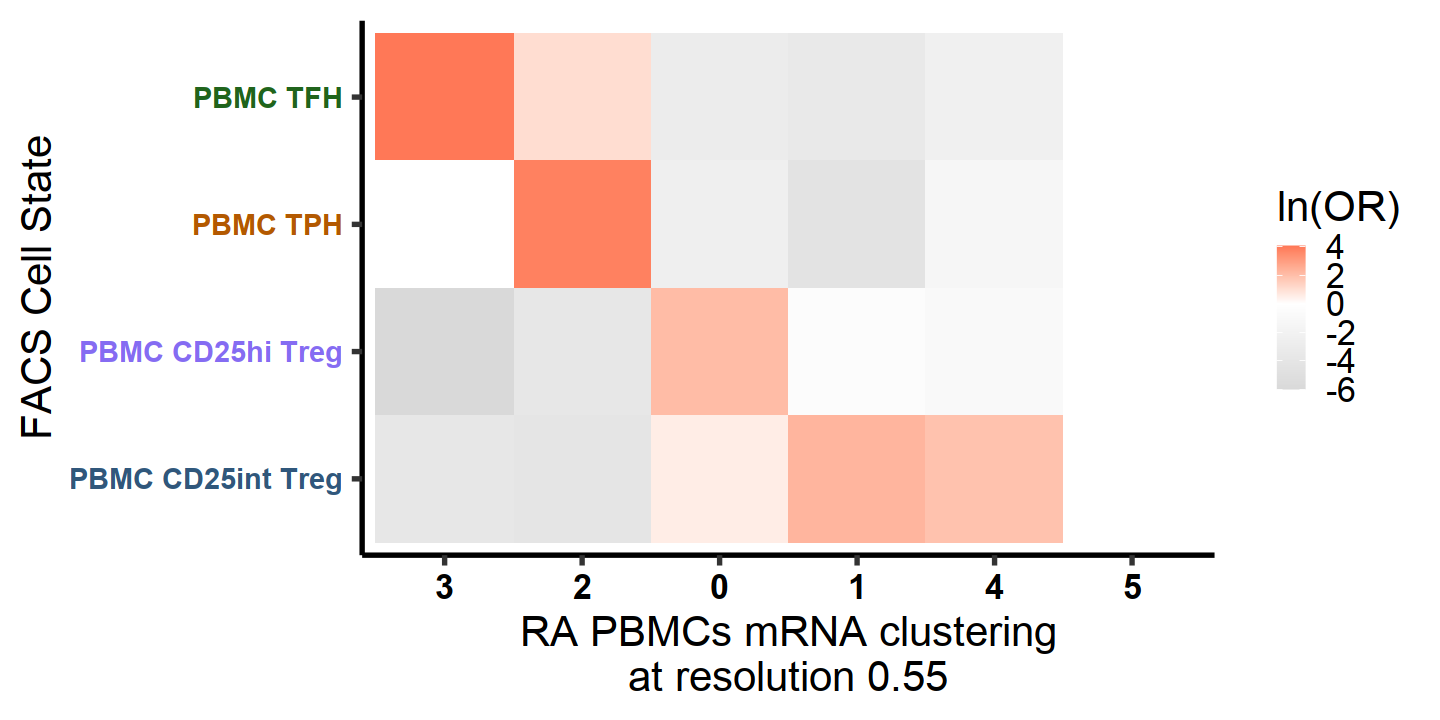

In [16]:
#Fig S15d right

mRNA_fisher_df <- calc_OR(meta,mRNA_res,hashtag_col)

mRNA_cluster_colors <- rep('black',length(unique(meta[,mRNA_res])))
names(mRNA_cluster_colors) <- sort(unique(meta[,mRNA_res]))

g <- plot_OR(mRNA_fisher_df, mRNA_res, hashtag_col,
             paste('RA PBMCs mRNA clustering\nat resolution 0.55'), paste('FACS Cell State'),
             c(3,2,0,1,4,5),HTO_order,clustColors=c(HTO_colors,mRNA_cluster_colors))
g <- g + theme(axis.text.x=element_text(size=20),axis.text.y=element_text(size=17))

options(repr.plot.height=6,repr.plot.width=12)
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,save_dir,'PBMCsuperstate_mRNA_ORheatmap',file_extension),
                            plot=g,units='in',height=6,width=12,dpi=600)

## Wilcoxon comparison by modality

### Treg

In [17]:
Treg_diffPeak_p2g <- unique(Treg_diffPeaks[,c('peak','gene')])
Treg_diffPeak_p2g <- Treg_diffPeak_p2g[which(Treg_diffPeak_p2g$gene %in% Treg_diffGenes$feature),]
Treg_peakSums <- rowSums(Treg_pxc_norm)

Treg_diffPeak_p2g <- unique_p2g_function(Treg_diffPeak_p2g,Treg_peakSums)
nrow(Treg_diffPeak_p2g)

[1] 11714

In [18]:
Treg_diffPeak_p2g <- Treg_diffPeak_p2g[which(Treg_diffPeak_p2g$peak %in% 
                                             rownames(peak_fragCt[which(peak_fragCt$Treg_binary>50),]) & 
                                             Treg_diffPeak_p2g$gene %in% 
                                             rownames(gene_UMICt[which(gene_UMICt$Treg_binary>50),])),]
nrow(Treg_diffPeak_p2g)

[1] 7208

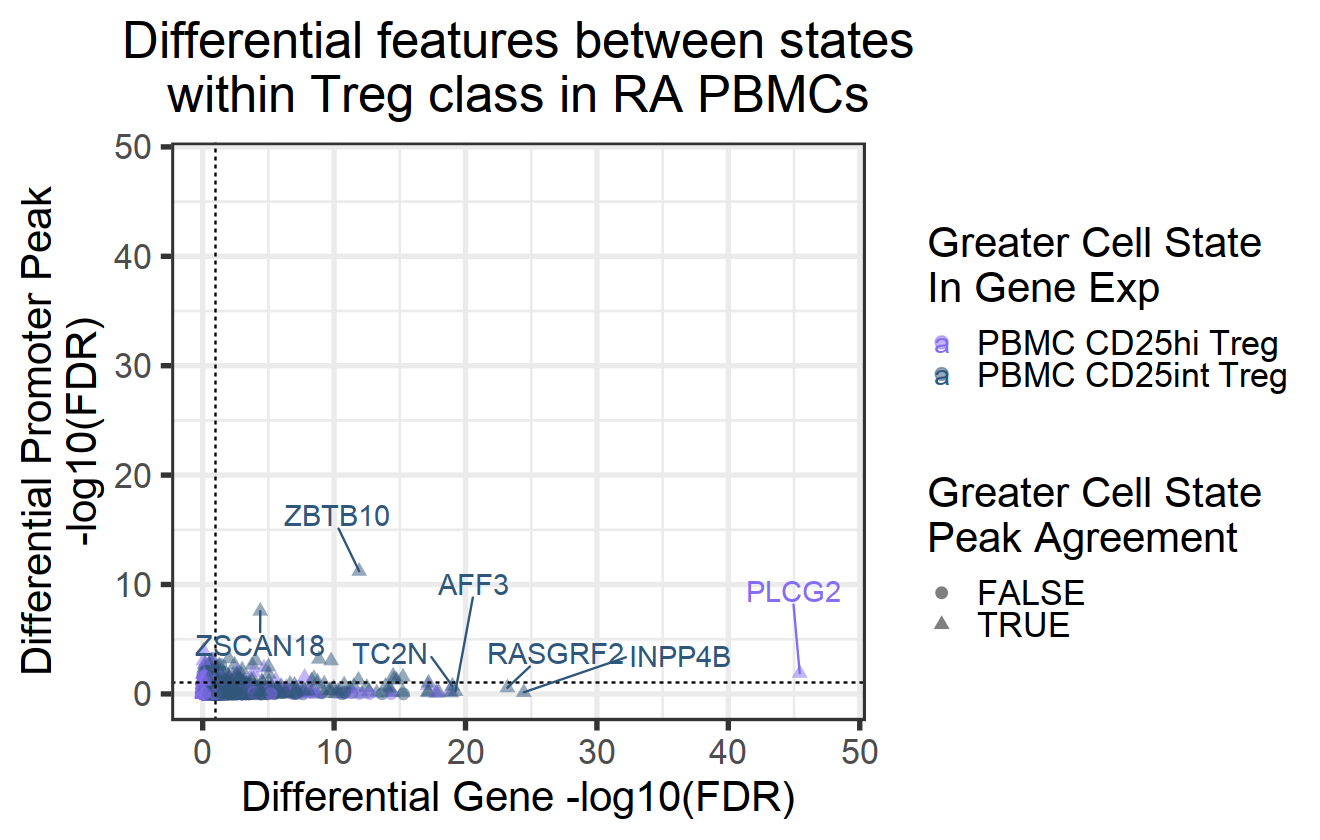

In [19]:
#Fig 7d

options(repr.plot.height=7,repr.plot.width=11)
r <- mrna_atac_differential_function(Treg_diffPeaks,Treg_diffGenes,Treg_diffPeak_p2g,
                                     label_peakBound=5, label_geneBound=19,color_vec=HTO_colors,
                                     this_title='Differential features between states\nwithin Treg class in RA PBMCs')
g <- r$plot
df <- r$data
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,save_dir,'PBMCsuperstate_FDR_Treg_byModality',file_extension),
           plot=g,units='in',height=7,width=11,dpi=600)
    write.table(df,paste(sep='',save_dir,'PBMCsuperstate_FDR_Treg_byModality',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

Warning message:
“Using alpha for a discrete variable is not advised.”


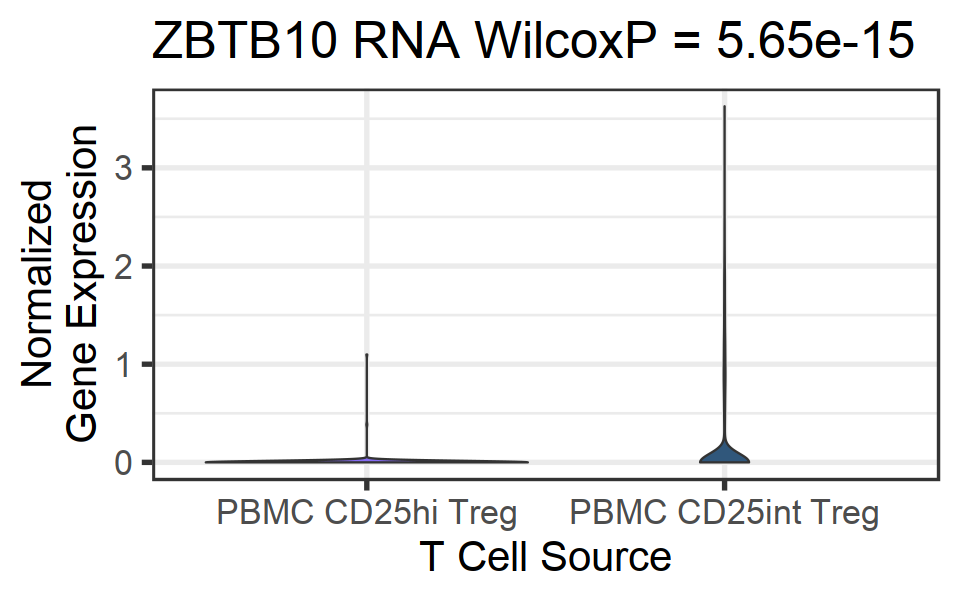

Warning message:
“Using alpha for a discrete variable is not advised.”


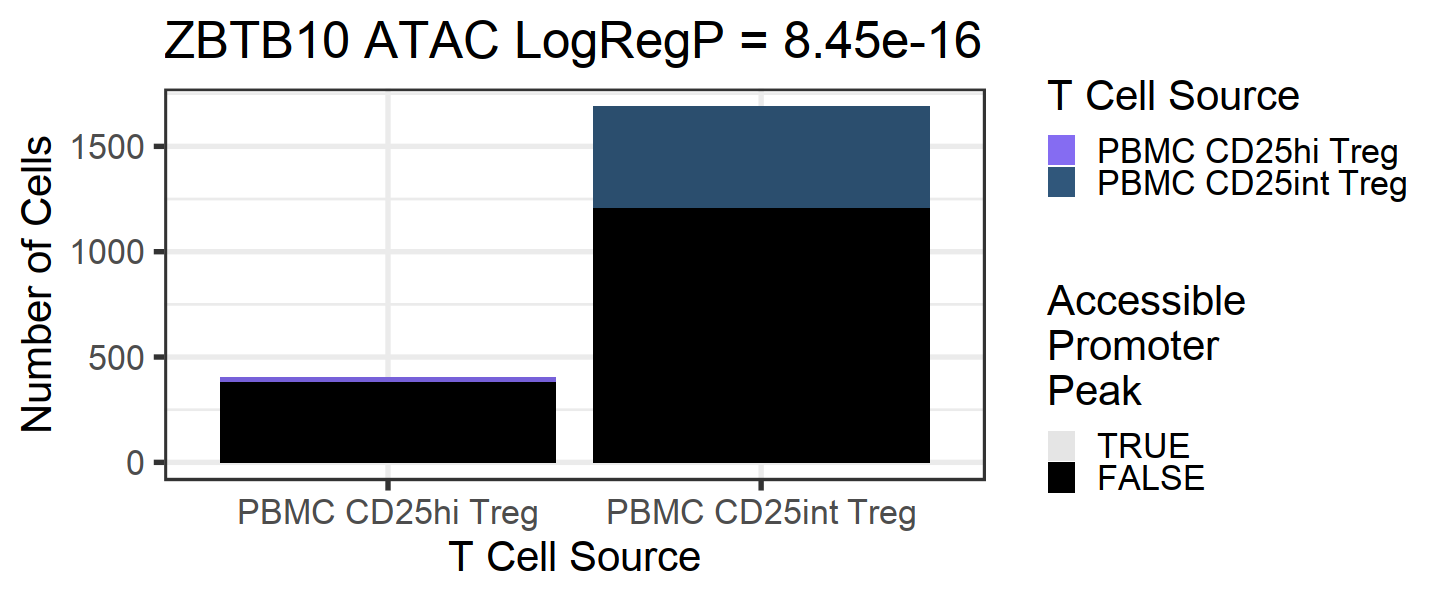

In [20]:
#Fig S15f

thisGene <- 'ZBTB10'
thisState <- 'PBMC CD25int Treg'
thisPeak <- Treg_diffPeak_p2g[which(Treg_diffPeak_p2g$gene==thisGene),'peak']
if(!identical(colnames(Treg_gxc_norm),colnames(Treg_pxc_norm))) stop('Cell naming issue')
toPlot <- cbind(meta[colnames(Treg_gxc_norm),],'gene_norm'=Treg_gxc_norm[thisGene,],
                'peak_norm'=Treg_pxc_norm[thisPeak,],'peak_binary'=ifelse(Treg_pxc_norm[thisPeak,]==0,FALSE,TRUE))

options(repr.plot.height=5,repr.plot.width=8)
g <- ggplot(toPlot,aes_string(x=hashtag_col,y='gene_norm',fill=hashtag_col)) + geom_violin() + 
        ggtitle(paste(thisGene,'RNA WilcoxP =',
                      signif(Treg_diffGenes[which(Treg_diffGenes$feature==thisGene & 
                                                  Treg_diffGenes$group==thisState),'pval'],3))) +
        labs(y='Normalized\nGene Expression',x='T Cell Source') +
        theme_bw(base_size=25) + scale_fill_manual(values=HTO_colors) + theme(legend.position="none")
print(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,save_dir,'PBMCsuperstate_Wilcoxon_Treg_',thisGene,'_RNA',
                                       file_extension),
                            plot=g,units='in',height=5,width=8,dpi=600)

options(repr.plot.height=5,repr.plot.width=12)
toPlot2 <- as.data.frame(table(toPlot[,c(hashtag_col,'peak_binary')]),stringsAsFactors=FALSE)
toPlot2$peak_binary <- factor(toPlot2$peak_binary,levels=c(TRUE,FALSE))
g <- ggplot(toPlot2,aes(x=snHTO_cellType,y=Freq)) + 
        geom_bar(position="stack", stat="identity",aes(fill=snHTO_cellType)) + scale_fill_manual(values=HTO_colors) + 
        geom_bar(position="stack", stat="identity",fill='black',aes(alpha=peak_binary)) + 
        ggtitle(paste(thisGene,'ATAC LogRegP =',
                      signif(Treg_diffPeaks[which(Treg_diffPeaks$peak==thisPeak & 
                                                  Treg_diffPeaks$cellType==thisState),'pval'],3))) + 
        labs(x='T Cell Source',y='Number of Cells',fill='T Cell Source',alpha='Accessible\nPromoter\nPeak') +
        theme_bw(base_size=25)
suppressMessages(print(g))

df <- toPlot2[,c('snHTO_cellType','peak_binary','Freq')]
colnames(df) <- c('T cell Source','Accessible Promoter Peak','Number of Cells')

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,save_dir,'PBMCsuperstate_LogReg_Treg_',
                      thisGene,'_ATAC',file_extension),
           plot=g,units='in',height=5,width=12,dpi=600)
    write.table(df,paste(sep='',save_dir,'PBMCsuperstate_LogReg_Treg_',
                         thisGene,'_ATAC',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

### TFH/TPH

In [21]:
TXH_diffPeak_p2g <- unique(TXH_diffPeaks[,c('peak','gene')])
TXH_diffPeak_p2g <- TXH_diffPeak_p2g[which(TXH_diffPeak_p2g$gene %in% TXH_diffGenes$feature),]
TXH_peakSums <- rowSums(TXH_pxc_norm)

TXH_diffPeak_p2g <- unique_p2g_function(TXH_diffPeak_p2g,TXH_peakSums)
nrow(TXH_diffPeak_p2g)

[1] 11713

In [22]:
TXH_diffPeak_p2g <- TXH_diffPeak_p2g[which(TXH_diffPeak_p2g$peak %in% 
                                           rownames(peak_fragCt[which(peak_fragCt$TXH_binary>50),]) & 
                                           TXH_diffPeak_p2g$gene %in% 
                                           rownames(gene_UMICt[which(gene_UMICt$TXH_binary>50),])),]
nrow(TXH_diffPeak_p2g)

[1] 5264

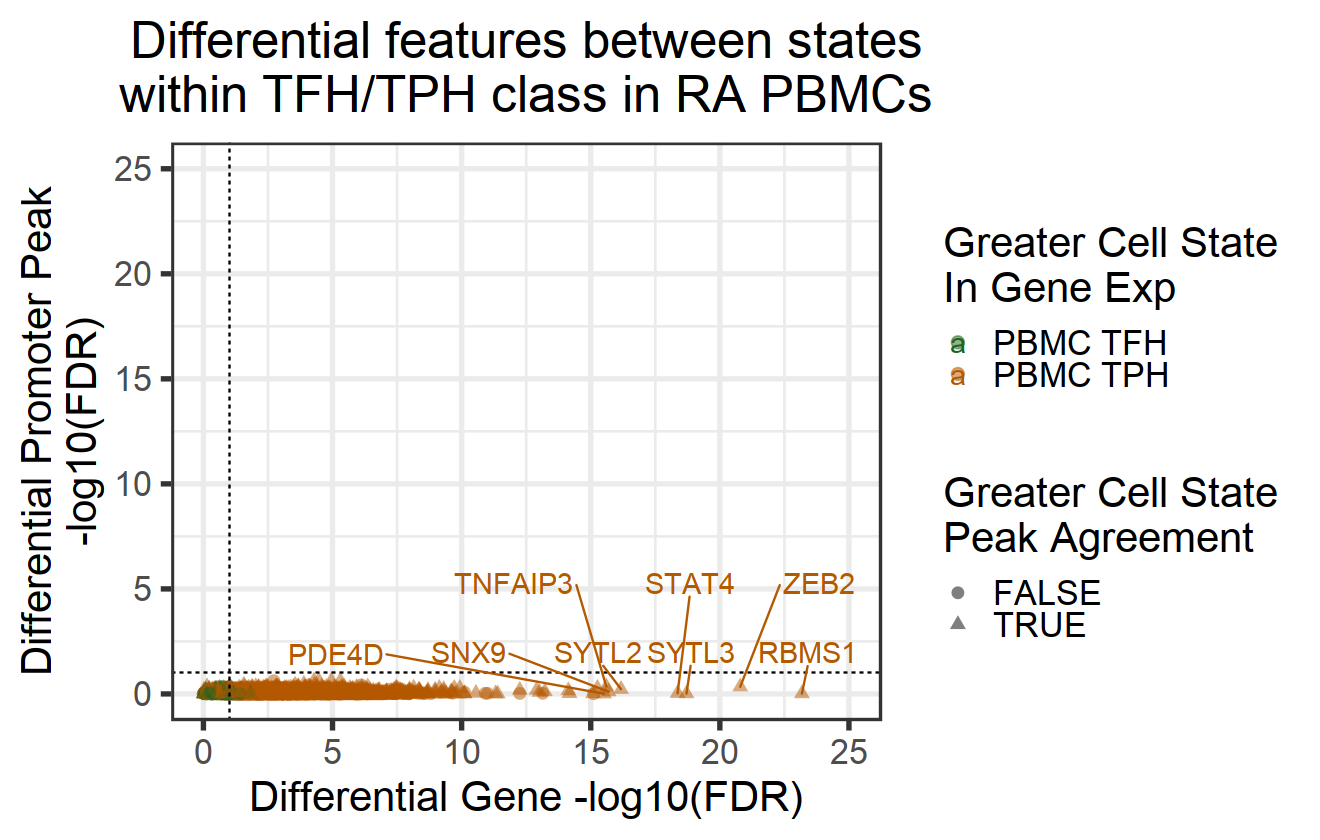

In [23]:
#Fig 7e

options(repr.plot.height=7,repr.plot.width=11)
r <- mrna_atac_differential_function(TXH_diffPeaks,TXH_diffGenes,TXH_diffPeak_p2g,
                                     label_peakBound=2, label_geneBound=15.5,color_vec=HTO_colors,
                                     this_title='Differential features between states\nwithin TFH/TPH class in RA PBMCs')
g <- r$plot
df <- r$data
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,save_dir,'PBMCsuperstate_FDR_TXH_byModality',file_extension),
           plot=g,units='in',height=7,width=11,dpi=600)
    write.table(df,paste(sep='',save_dir,'PBMCsuperstate_FDR_TXH_byModality',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

Warning message:
“Using alpha for a discrete variable is not advised.”


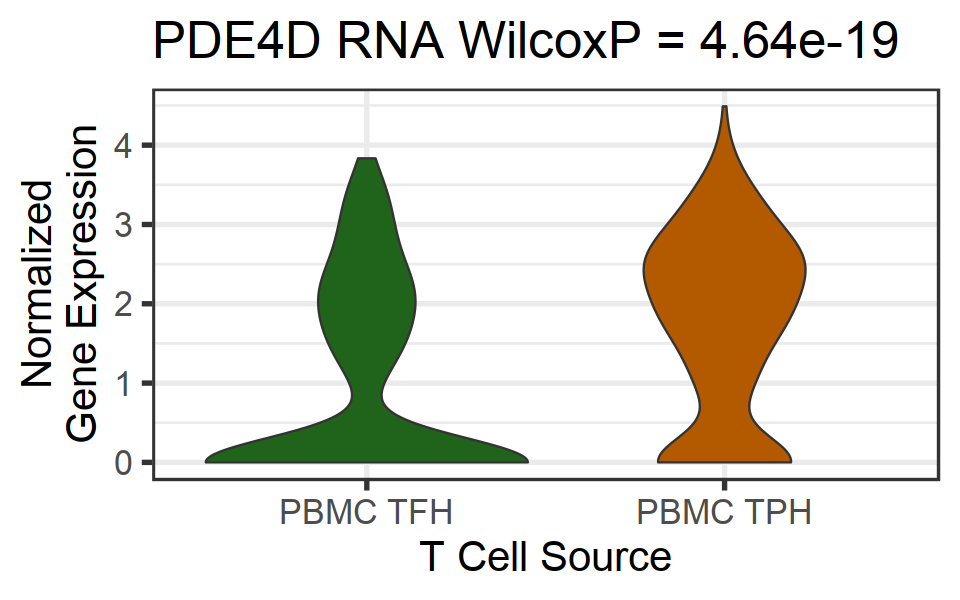

Warning message:
“Using alpha for a discrete variable is not advised.”


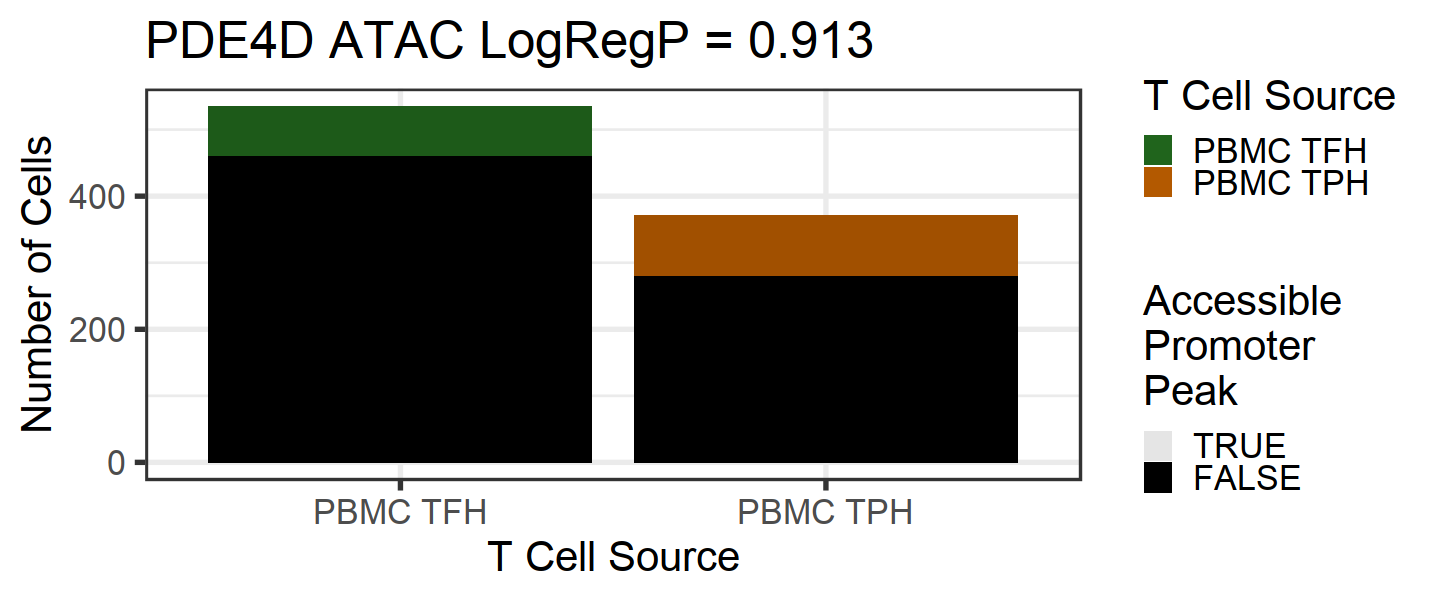

In [24]:
#Fig S15e

thisGene <- 'PDE4D'
thisState <- 'PBMC TPH'
thisPeak <- TXH_diffPeak_p2g[which(TXH_diffPeak_p2g$gene==thisGene),'peak']
if(!identical(colnames(TXH_gxc_norm),colnames(TXH_pxc_norm))) stop('Cell naming issue')
toPlot <- cbind(meta[colnames(TXH_gxc_norm),],'gene_norm'=TXH_gxc_norm[thisGene,],
                'peak_norm'=TXH_pxc_norm[thisPeak,],'peak_binary'=ifelse(TXH_pxc_norm[thisPeak,]==0,FALSE,TRUE))

options(repr.plot.height=5,repr.plot.width=8)
g <- ggplot(toPlot,aes_string(x=hashtag_col,y='gene_norm',fill=hashtag_col)) + geom_violin() + 
        ggtitle(paste(thisGene,'RNA WilcoxP =',
                      signif(TXH_diffGenes[which(TXH_diffGenes$feature==thisGene & 
                                                  TXH_diffGenes$group==thisState),'pval'],3))) +
        labs(y='Normalized\nGene Expression',x='T Cell Source') +
        theme_bw(base_size=25) + scale_fill_manual(values=HTO_colors) + theme(legend.position="none")
print(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,save_dir,'PBMCsuperstate_Wilcoxon_TXH_',thisGene,'_RNA',
                                       file_extension),
                            plot=g,units='in',height=5,width=8,dpi=600)

options(repr.plot.height=5,repr.plot.width=12)
toPlot2 <- as.data.frame(table(toPlot[,c(hashtag_col,'peak_binary')]),stringsAsFactors=FALSE)
toPlot2$peak_binary <- factor(toPlot2$peak_binary,levels=c(TRUE,FALSE))
g <- ggplot(toPlot2,aes(x=snHTO_cellType,y=Freq)) + 
        geom_bar(position="stack", stat="identity",aes(fill=snHTO_cellType)) + scale_fill_manual(values=HTO_colors) + 
        geom_bar(position="stack", stat="identity",fill='black',aes(alpha=peak_binary)) + 
        ggtitle(paste(thisGene,'ATAC LogRegP =',
                      signif(TXH_diffPeaks[which(TXH_diffPeaks$peak==thisPeak & 
                                                 TXH_diffPeaks$cellType==thisState),'pval'],3))) + 
        labs(x='T Cell Source',y='Number of Cells',fill='T Cell Source',alpha='Accessible\nPromoter\nPeak') +
        theme_bw(base_size=25)
suppressMessages(print(g))

df <- toPlot2[,c('snHTO_cellType','peak_binary','Freq')]
colnames(df) <- c('T cell Source','Accessible Promoter Peak','Number of Cells')

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,save_dir,'PBMCsuperstate_LogReg_TXH_',
                      thisGene,'_ATAC',file_extension),
           plot=g,units='in',height=5,width=12,dpi=600)
    write.table(df,paste(sep='',save_dir,'PBMCsuperstate_LogReg_TXH_',
                         thisGene,'_ATAC',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

## Session Info

In [25]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/kew47/miniconda3/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] repr_1.0.1         gridExtra_2.3      RColorBrewer_1.1-2 scales_1.1.1      
 [5] viridis_0.5.1      viridisLite_0.3.0  ggrepel_0.8.2      ggrastr_0.2.3     
 [9] tidyr_1.0.3        stringr_1.4.0      ggpubr_0.4.0       ggplot2_3.3.0     
[13] presto_1.0.0       Rcpp_1.0.4.6       ROCR_1.0-7         gplots_3.0.1.1    
[17] Rmisc_1.5.1        plyr_1.8.6         lattice_0.20-41    gtools_3.8.2      
[21] Matrix_1.2-18     

loaded via a namespace (and not attached):
 [1] digest_0.6.25       IRdisplay_0.7.0     R6_2.4.1           
 [4] cellranger_1.1.0    backports_1.1.6     evaluate_0.14      
